In [13]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import time

In [14]:
# SAMPLE DATA
ds = xr.open_mfdataset(
    "/Users/brianpm/Documents/model_output/control/e2p3b09.F2000climo.ne30pg3.ctl002.cam.h0.*",
    decode_times=False,
)
t = ds["time_bnds"].mean(dim="nbnd")
t.attrs = ds["time"].attrs
ds = ds.assign_coords({"time": t})
ds = xr.decode_cf(ds)

# SURFACE TEMPERATURE
da = ds["TS"]

# for np version to work, need to trim to whole years
da = da.isel(
    time=slice(None, np.argwhere((da.time.dt.month == 12).values).max() + 1)
)  # +1 b/c slice is exclusive on the end.
print(da.time.max())
print(da.shape)

<xarray.DataArray 'time' ()> Size: 8B
array(cftime.DatetimeNoLeap(10, 12, 16, 12, 0, 0, 0, has_year_zero=True),
      dtype=object)
(120, 192, 288)


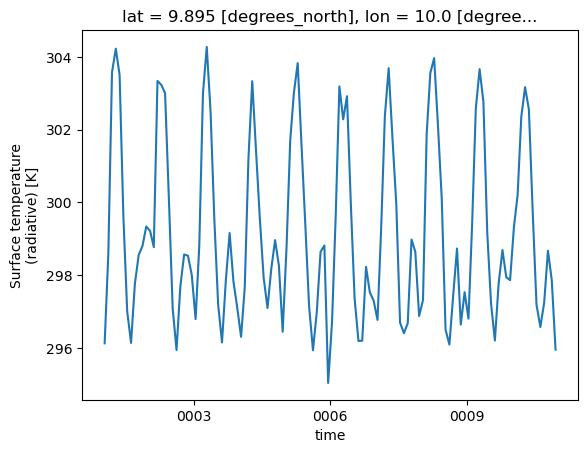

In [15]:
# SAMPLE TIME SERIES: TS at a point
dts = da.sel(lat=10, lon=10, method="nearest").compute()  # compute to force into memory
dts.plot()

# Rolling Mean

Apply a rolling mean, or "moving average" or "running mean", to the data.

Say we wanted to look at the 3-month running average TS.

Naive approach: (118,), first value: 299.4286702473958, time: 0.01500391704030335 seconds
Convolve approach: (118,), first value: 299.42866007486975, time: 0.00041874987073242664 seconds
Xarray rolling: (120,), first_value: nan (don't worry), time: 0.0046218750067055225 seconds
convolve / loop : 0.027909369907043978, xr / loop: 0.30804455891686783


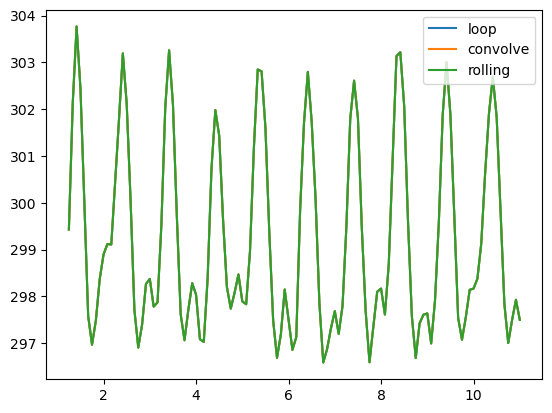

In [16]:
#
# Running mean (1-D example)
#

#
# Just Numpy
#
npts = 3  # 3 month running mean

# naive approach
t0 = time.perf_counter()
np_loop_mean = np.array(
    [dts[i : i + npts].sum() / npts for i in range(len(dts) - npts + 1)]
)
np_loop_mean_toxr = xr.DataArray(
    np_loop_mean, dims=["time"], coords={"time": dts.time[npts - 1 :]}
)  # back to DataArray
loop_timer = time.perf_counter() - t0
print(
    f"Naive approach: {np_loop_mean.shape}, first value: {np_loop_mean[0].item()}, time: {loop_timer} seconds"
)

# Use convolve
t1 = time.perf_counter()
np_run_mean = np.convolve(dts, np.ones(npts) / npts, mode="valid")
np_run_mean_toxr = xr.DataArray(
    np_run_mean, dims=["time"], coords={"time": dts.time[npts - 1 :]}
)  # to DataArray
conv_timer = time.perf_counter() - t1
print(
    f"Convolve approach: {np_run_mean.shape}, first value: {np_run_mean[0].item()}, time: {conv_timer} seconds"
)  # reduced by npts-1 points

# check how convolve works
# print(np.convolve(np.array([1,1,1,2,2,2,3,3,3]), np.ones(npts)/npts, mode='valid'))
# so it drops the first npts-1, i.e., first values is X[0:npts].mean()
# https://numpy.org/doc/stable/reference/generated/numpy.convolve.html
# Note that the second function gets flipped, but doesn't matter in this case b/c symmetry.

# Use xarray's rolling method:
t2 = time.perf_counter()
xr_roll_mean = dts.rolling(time=3).mean().compute()
roll_timer = time.perf_counter() - t2
print(
    f"Xarray rolling: {xr_roll_mean.shape}, first_value: {xr_roll_mean[0].item()} (don't worry), time: {roll_timer} seconds"
)

fig, ax = plt.subplots()
ax.plot(
    np_loop_mean_toxr.time.dt.year + np_loop_mean_toxr.time.dt.month / 12,
    np_loop_mean_toxr,
    label="loop",
)
ax.plot(
    np_run_mean_toxr.time.dt.year + np_run_mean_toxr.time.dt.month / 12,
    np_run_mean_toxr,
    label="convolve",
)
ax.plot(
    xr_roll_mean.time.dt.year + xr_roll_mean.time.dt.month / 12,
    xr_roll_mean,
    label="rolling",
)
ax.legend()

# ratio of convolve to loop:
print(f"convolve / loop : {conv_timer/loop_timer}, xr / loop: {roll_timer / loop_timer}")

## Bigger data, more dimensions

Extend from 1-d time series to full (time, lat, lon) calculation using `da`

In [17]:
# xarray:
t2 = time.perf_counter()
xr_roll_mean = (
    da.rolling(time=3).mean().compute()
)  # mean or "rolling" object is along the rolled dimension
roll_timer = time.perf_counter() - t2
print(
    f"Xarray rolling: {type(xr_roll_mean)}, {xr_roll_mean.shape}, time: {roll_timer} seconds"
)

# convolve takes two 1-dimensional arrays
t1 = time.perf_counter()
np_conv_mean = np.apply_along_axis(
    lambda m: np.convolve(m, np.ones(npts) / npts, mode="valid"), axis=0, arr=da.values
)
conv_timer = time.perf_counter() - t1
print(
    f"Numpy convolve : {type(np_conv_mean)}, {np_conv_mean.shape}, time: {conv_timer} seconds"
)

# loop
t0 = time.perf_counter()
np_loop_mean = np.array(
    [da[i : i + npts, :, :].mean(axis=0) for i in range(da.shape[0] - npts + 1)]
)
# np_loop_mean_toxr =  xr.DataArray(np_loop_mean, dims=['time'], coords={"time":dts.time[npts-1:]})  # back to DataArray
loop_timer = time.perf_counter() - t0
print(
    f"Loop approach: {type(np_loop_mean)}, {np_loop_mean.shape}, time: {loop_timer} seconds"
)
print(f"convolve / loop : {conv_timer/loop_timer}, xr / loop: {roll_timer / loop_timer}")

Xarray rolling: <class 'xarray.core.dataarray.DataArray'>, (120, 192, 288), time: 0.22189995809458196 seconds
Numpy convolve : <class 'numpy.ndarray'>, (118, 192, 288), time: 0.2477847500704229 seconds
Loop approach: <class 'numpy.ndarray'>, (118, 192, 288), time: 0.522114000050351 seconds
convolve / loop : 0.47457978534673906, xr / loop: 0.42500288839828587


In [18]:
%%time
# NOTE: we should actually make this a WEIGHTED MEAN because months have different number of days
# reference: https://tutorial.xarray.dev/intermediate/01-high-level-computation-patterns.html

# xarray:
t2 = time.perf_counter()
# the weights:
w = da.time.dt.daysinmonth
# to apply the weights correctly, they need to be "windowed" too
ww = w.rolling(time=3, min_periods=1).construct("window")
xr_roll_mean = (
    da.rolling(time=3)
    .construct("window")
    .weighted(ww.fillna(0))
    .mean(dim="window")
    .compute()
)
roll_timer = time.perf_counter() - t2
print(
    f"Xarray rolling: {type(xr_roll_mean)}, {xr_roll_mean.shape}, time: {roll_timer} seconds"
)

print(xr_roll_mean.shape)
# leaving numpy implementation as an exercise :p

Xarray rolling: <class 'xarray.core.dataarray.DataArray'>, (120, 192, 288), time: 0.16404733387753367 seconds
(120, 192, 288)
CPU times: user 211 ms, sys: 74.4 ms, total: 285 ms
Wall time: 164 ms


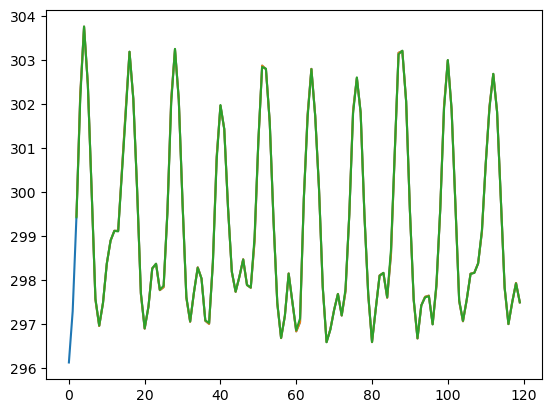

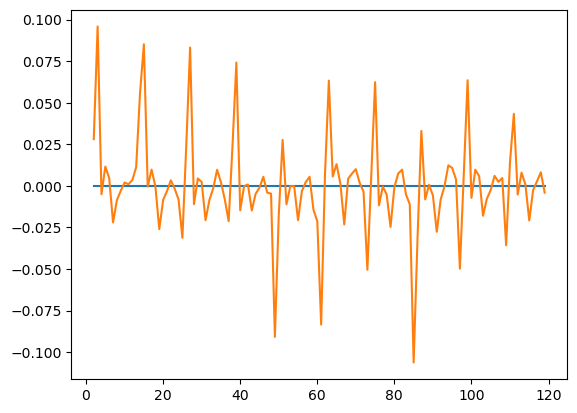

In [102]:
#
# It isn't totally obvious that would work correctly,
# so here I show that it actually does by
# going back to our sample data point and
# calculating the weighted average step-by-step
#
z = xr_roll_mean.sel(lat=10, lon=10, method="nearest")

wgt = dts.time.dt.daysinmonth  # weights(time)
wtimesx = dts * wgt  # data time weight at each time
wxroll = wtimesx.rolling(time=3).sum()  # the 3-point rolling sum of x*w
wrolltotal = wgt.rolling(time=3).sum()  # the 3-point rolling sum of w
correct = wxroll / wrolltotal  # the correctly weighted mean of each 3-point sample
correct

incorrect = dts.rolling(time=3).mean()

plt.plot(z)
plt.plot(correct)
plt.plot(incorrect)
plt.show()
plt.plot(z - correct)
plt.plot(z - incorrect)

# Reshaping Arrays

Here we take the (time, lat, lon) data in `da`, and we imagine that we want to reshape to (year, month, lat, lon).

In [20]:
def reshape_to_yearly(data):
    """
    Reshape an array from (time, lat, lon) to (year, month, lat, lon).

    Parameters:
    data (numpy.ndarray): Input array with shape (time, lat, lon)

    Returns:
    numpy.ndarray: Reshaped array with shape (year, month, lat, lon)
    """
    time, lat, lon = data.shape

    # Calculate the number of years
    n_years = time // 12

    # Ensure that the time dimension is divisible by 12
    if time % 12 != 0:
        raise ValueError("The time dimension must be divisible by 12.")

    # Reshape the array
    reshaped = data.reshape(n_years, 12, lat, lon)

    return reshaped


# Example usage:
# Assuming you have a data array with shape (time, lat, lon)
time, lat, lon = 120, 180, 360  # 10 years of monthly data
data = np.random.rand(time, lat, lon)

# Reshape the data
yearly_data = reshape_to_yearly(data)

print("Original shape:", data.shape)
print("Reshaped to yearly:", yearly_data.shape)

Original shape: (120, 180, 360)
Reshaped to yearly: (10, 12, 180, 360)


In [21]:
def reshape_to_time_series(data):
    """
    Reshape an array from (year, month, lat, lon) back to (time, lat, lon).

    Parameters:
    data (numpy.ndarray): Input array with shape (year, month, lat, lon)

    Returns:
    numpy.ndarray: Reshaped array with shape (time, lat, lon)
    """
    year, month, lat, lon = data.shape

    # Calculate the total number of time steps
    time = year * month

    # Reshape the array
    reshaped = data.reshape(time, lat, lon)

    return reshaped


# Example usage:
# Assuming you have a data array with shape (year, month, lat, lon)
year, month, lat, lon = 10, 12, 180, 360
yearly_data = np.random.rand(year, month, lat, lon)

# Reshape the data back to time series
time_series_data = reshape_to_time_series(yearly_data)

print("Original shape (year, month, lat, lon):", yearly_data.shape)
print("Reshaped to time series (time, lat, lon):", time_series_data.shape)

Original shape (year, month, lat, lon): (10, 12, 180, 360)
Reshaped to time series (time, lat, lon): (120, 180, 360)


In [22]:
%%time 
npapproach = reshape_to_yearly(da.values)

print("Original shape:", da.shape)
print("Reshaped shape:", npapproach.shape)

Original shape: (120, 192, 288)
Reshaped shape: (10, 12, 192, 288)
CPU times: user 267 ms, sys: 16.9 ms, total: 284 ms
Wall time: 280 ms


## xarray

Xarray has ability to "stack" and "unstack" dimensions.

This comes in handy when applying functions that expect a specific dimensionality.

Here we use it to quickly reshape an array. Next we'll show that how that could be used in a calculation.

In [23]:
%%time 

# Extract year and month from the time coordinate
year = da.time.dt.year
month = da.time.dt.month

# assign new coords
da = da.assign_coords(year=("time", year.data), month=("time", month.data))

# reshape the array to (..., "month", "year")
reshaped_da = da.set_xindex(("year", "month")).unstack("time").transpose("year","month","lat","lon")

print("Original shape:", da.shape)
print("Reshaped shape:", reshaped_da.shape)

Original shape: (120, 192, 288)
Reshaped shape: (10, 12, 192, 288)
CPU times: user 7.32 ms, sys: 2.44 ms, total: 9.75 ms
Wall time: 12.9 ms


# Running climatology

Combine the running average and the reshaping to construct a "running climatology".

Apply running average over N years, but grouping each calendar month instead.

In [103]:
def to_monthly(ds):
    """This function takes monthly data,
    assigns coordinates for year and month
    sets year and month as indices and
    unstacks to have separate year and month dimensions.
    """
    year = ds.time.dt.year
    month = ds.time.dt.month

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), month=("time", month.data))

    # reshape the array to (..., "month", "year")
    return ds.set_xindex(("year", "month")).unstack("time")


def rolling_monthly_mean(z, winsize):
    """Given data, z, and winsize in years,
    apply rolling mean across calendar months.
    IF winsize=5, then average 5 januarys, 5 februarys, etc.
    RETURNS data same shape as z, but with this rolling monthly mean applied.
    """
    zus = to_monthly(z).transpose(
        "year", "month", "lat", "lon"
    )  # splits time into "year" and "month" dims
    zus_rol = zus.rolling(year=winsize).mean(
        dim="year"
    )  # average applied along "year" dim
    zus_tim = zus_rol.stack(
        time=("year", "month")
    )  # makes time a MultiIndex, entries (year, month)
    # Assign original time and return:
    zus_tim = zus_tim.drop_vars(["time", "year", "month"])
    zus_tim = zus_tim.assign_coords({"time": z.time})
    return zus_tim

/var/folders/3y/4dzlw6yj5bj8ds39vpvyg92m0000gp/T/ipykernel_54237/3533948294.py:24: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['year']'. Passing the 'dim' kwarg to reduction operations has no effect.
  zus_rol = zus.rolling(year=winsize).mean(dim='year') # average applied along "year" dim
/var/folders/3y/4dzlw6yj5bj8ds39vpvyg92m0000gp/T/ipykernel_54237/3533948294.py:24: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['year']'. Passing the 'dim' kwarg to reduction operations has no effect.
  zus_rol = zus.rolling(year=winsize).mean(dim='year') # average applied along "year" dim
/var/folders/3y/4dzlw6yj5bj8ds39vpvyg92m0000gp/T/ipykernel_54237/3533948294.py:24: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['year']'. Passing the 'dim' kwarg to reduction operations has no effect.
  zus_rol = zus.rolling(year=winsize).mean(dim='year') # average applied along "year" dim
/var/folders/3y/4dzlw6yj5bj8ds39vp

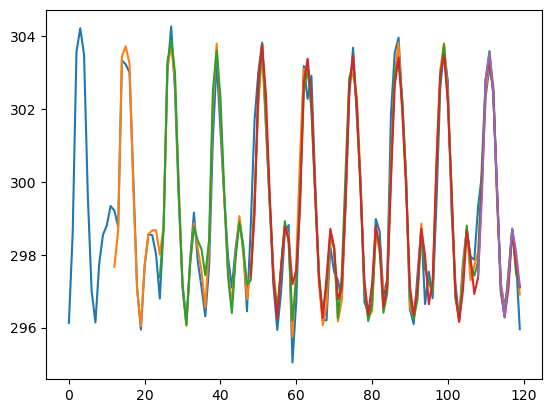

In [116]:
da_2yr = rolling_monthly_mean(da, 2)

da_3yr = rolling_monthly_mean(da, 3)

da_5yr = rolling_monthly_mean(da, 5)

da_10yr = rolling_monthly_mean(da, 10)


# compare the time series:
z2 = da_2yr.sel(lat=10, lon=10, method="nearest")
z3 = da_3yr.sel(lat=10, lon=10, method="nearest")
z5 = da_5yr.sel(lat=10, lon=10, method="nearest")
z10 = da_10yr.sel(lat=10, lon=10, method="nearest")


plt.plot(dts)
plt.plot(z2)
plt.plot(z3)
plt.plot(z5)
plt.plot(z10)

In [117]:
z5.compute()

<xarray.DataArray 'TS' (time: 120)> Size: 480B
array([      nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
       297.4461 , 299.1061 , 302.8229 , 303.77786, 302.39996, 299.6352 ,
       297.2723 , 296.25317, 297.69183, 298.77823, 298.45068, 297.19025,
       297.56354, 299.31543, 302.746  , 303.3898 , 302.28342, 299.71368,
       297.3454 , 296.26337, 297.38068, 298.71356, 298.19528, 296.78253,
       297.07513, 299.42276, 302.55286, 303.48123, 302.0354 , 299.68576,
       297.26694, 296.35645, 297.17773, 298.79584, 298.21637, 296.55557,
       297.17917, 300.03625, 302.66544, 303.41965, 301.95996, 299.80292,
       297.1302 , 296.345  , 297.09738, 298.71054, 297.97806, 296.64   ,
       297.27887, 300.3853 , 302.94336, 303.486  , 302.2294 , 299.7294 ,
       296.98773, 296.16644, 297.01898, 298.65582, 297.91388, 296.92325,
       297.3873 , 300.08502, 302.8112 , 303.35394, 302.42407, 299.80142,
       296.99814, 296.2945 , 297.0707 , 298.66183, 297.72418, 297.10617],
      dtype=float32)
Coordinates:
    lat      float64 8B 9.895
    lon      float64 8B 10.0
  * time     (time) object 960B 0001-01-16 12:00:00 ... 0010-12-16 12:00:00
Attributes:
    units:          K
    long_name:      Surface temperature (radiative)
    cell_methods:   time: mean
    cell_measures:  area: area